# Applied Micro Study Group: Computation
*May 2, 2020*

*Mauro Moretto, Faith Feng*

## Overview:
1. Improve your workflow with JupyterLab, some coding tips
2. Simulate data of the single agent job search model based on *Application 1: Search Model* in *Nonstationary Dynamic Models with Finite Dependence* (Arcidiacono and Miller, 2019)
3. Estimation by minimum distance with CCP 
4. Estimation by finite dependence with CCP

## 1. JupyterLab: Smoothing Your Workflow

- JupyterLab is an augmentation of the very popular Jupyter Notebook which supports over 40 programming languages such as Python, R, Julia.


- Like Jupyter Notebook, one can keep the comments and notes together with your codes. One can display the results of your code cleanly as well. (For keeping notes in Markdown, see [Markdown Cheatsheet](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#links). Mathematics formula are essentially the same as LaTex.)


- So it is very good for developing codes since you can record your ideas and experiment your codes at the same place.


- However, Jupyter Notebook (file type *.ipynb* instead of *.py*) is slower than compiling Python (*.py*) codes in terminal, so people usually just use it to experiment ideas, keep records of code development or presenting codes.


- With JupyterLab, one can transfer the codes easily to traditional Python files and compile in terminals.

### A touch of software engineering: Top-Down v.s. Bottom-Up Design

- Top-Down: Write the big framework first, then fill in the smaller functions that the big framework needs.

    *advantage*: no need to think about every little details of implementation first; it can help you figure out what kind of supporting functions you need, and makes project management easier.

    *disadvantage*: no coding can start until there is a thorough understanding of the entire structure of the project.

- Bottom-Up: Write the smaller elements first, then write the big framework.

    *advantage*: it is easier to test the smaller functions as soon as you create them
    
    *disadvantage*: it is usually easier to lose track of the big framework in which the small functions operate, and may lead to a non-optimized implementation of such functions

### Good code styles can help you in the long-run

It is generally good pratice to:

- __name your variables and functions well__ Don't be lazy to write short abbreviations of names that are hard to understand)  

- __avoid magic numbers__ (unique values with unexplained meaning or multiple occurrences which could be replaced with named constants) to clarify meaning, so that other people (including yourself after not working on the project for a while) can quickly understand what's going on.  

- __avoid copy-pasting your code__ Instead, write functions or classes with changeable parameters.  

- __minimize the usage of global variables__ They can be really messy in a medium or large sized project, as they can easily affect what happens in your code. And at the same time, they can be modified by any part of your program. See *Global variables are BAD* (http://wiki.c2.com/?GlobalVariablesAreBad)

### Why Python is not that bad?

### - Community support:

| Language| Registered Packages| GitHub Projects | Reddit | Job Postings |
| :---   |     :---:           |     :---:       | :---:  |    :---:    |
| Python | 176,369             |    2,182,259    | 350k   | 30,328      |
| R      | 14,094              |      561,434    | 13.5k  | 8,563       |
| Julia  | over 2,400          |       16,394    | 6.5k   | 203         |

Data Sources:

*Registered packages: Pypi.org (Python), R-CRAN (R), Julialang (Julia);

*GitHub projects: from GHTorrent data collected in 2018; 

*Reddit: members of subreddits r/Python, r/Rlanguage and r/Julia; 

*Job posting: search by "language programming" (language=Python, R, Julia) on Indeed.com (Apr 17, 2019)  


### - Speed:

Python is slow compared to low-level languages like C/C++, Java .etc for mainly 2 reasons:
1. It is interpreted rather than compiled (it translates higher level languages into lower-level/faster languages). Common problem for all high-level languages.
2. Global Interpreter Lock (GIL): prevents multi-threading, but it greatly simplifies programming complexity faced by developers.

However, there are ways to boost the performance in Python (such as multiprocessing). And it is important to keep in mind that, most of the times, especially for not so professionally trained programmers (such as myself), the greatest restriction on the performance is the underlying algorithm of the program that one writes.

*Yes, the performance matters. But the user/developer experience also matters. Python is known for being simple to program, easy to read and maintain.*

__Conclusion: Don't use Python to program fancy video games. But for most of data analysis purposes, it is not necessarily low-performing, and it has much more community supports.__

## 2. Data Simulation

### A Simple Job Search Model

- Each period $t \in \{1, \cdots, T\}$, an individual may stay home ($d_{1t} = 1$) or apply for temporary employment setting ($d_{2t}=1$). 

- Job applicants are successful with probability $\lambda(x_t)$, and the value of the position depends on the experience of the individual denoted by $x \in \{1, \cdots, X\}$. 
$$\lambda(x_{t}) = 0.2\frac{x_t}{(T-1)}+0.8, ~~ x_t \in \{0, \cdots, T-1\}$$

- If the individual works his experience increases by one unit, and remains at the current level otherwise.

- The preference primitives are given by the current utility from staying home, denoted by $u_{1}(x_t) $, and the utility of working $u_2(x_t)$.
$$ u_{1}(x_t) = 0, \\  u_2(x_t) = \beta_0 + \beta_1 \left( \frac{x_t}{T-1} \right) $$

- Data generating process parameters: $\beta_0 = -2.4, ~ \beta_1 = 8, ~ \delta = 0.9$

- Error term distribution: $\epsilon_{1t}, ~\epsilon_{2t}$ are independently and identically distributed, following Type 1 Extreme Value distribution

In [ ]:
import numpy as np
import pandas as pd
import functools, itertools
import os, time, random
import matplotlib.pyplot as plt

### Compute Future/Continuation Value

* Let the conditional choice value be:
$$ v_{jt}(x_t) = u_{jt}(x_t) + \delta E[V_{t+1}(x_{t+1}) | x_{t}, j]$$
Here we're computing the second part of the total conditional value, where:
$$
E[V_{t+1}(x_{t+1}) | x_{t}, j] = E_{x_{t+1}, \epsilon_{1t+1},\epsilon_{2t+1}}\left[\max\left\{ u_{1t+1}(x_{t+1}) + \epsilon_{1t+1} + \delta E[V(x_{t+2})|x_{t+1}, j=1], \\
u_{2t+1}(x_{t+1}) + \epsilon_{2t+1} + \delta E[V(x_{t+2})|x_{t+1}, j=2]\right\} |~x_t, j \right]
$$

* The transition of state variable $x_t$:
$$
F(x_{t+1} = x_t |x_t, j=1) = 1 \\
F(x_{t+1} = x_t |x_t, j=2) = 1-\lambda (x_{t}) \\
F(x_{t+1} = x_t+1 |x_t, j=2) = \lambda (x_{t})
$$

* So with current work experience $x_t$, if the current choice is $d_t=1$, the work experience next period $x_{t+1}$ is $x_t$ for sure. The continuation value at $t$ is $V(x_t)$.
But if $d_t=2$, the work experience next period can be $x_t$ or $x_t+1$. The continuation value at $t$ is $\lambda(x_t) V_{t+1}(x_t+1)+(1-\lambda_(x_t)) V_{t+1}(x_t)$.

* Here we compute the value function using Monte Carlo method, that is, we compute the expectation by taking an average of many simulations.

\begin{gather*}
\hat{V}_t(x_t) = \frac{1}{N} \sum_{i=1}^N \max \left\lbrace \epsilon_H^i + u_H(x_t) + \delta \hat{V}_{t+1}(x_{t}), \\
\epsilon_W^i + (1-\lambda(x_t)) \left[u_H(x_t) + \delta \hat{V}_{t+1}(x_{t}) \right] + \lambda(x_t) \left[u_W(x_t) + \delta \hat{V}_{t+1}(x_{t}+1) \right]  \right\rbrace
\end{gather*}

* Computation through simulation can be pretty expensive, and can introduce some noise. This is not a big problem in this case, but keep in mind that we are dealing with a very simple problem, where the state space is uni-dimensional. Is there any alternative way to compute the does not rely on simulation? 

* We can use the properties at the Type 1 Extreme Value. Suppose that we have $N$ Gumbel random variables $\varepsilon^i$ with location parameter $0$, and same scale parameter $\sigma$. 

\begin{gather*}
\mathbb{E}\left[ \max_{i=1,\cdots,N} \left( \varepsilon^i + \mu^i  \right) \right] & = \gamma \sigma + \log \left( \sum_{i=1}^N \exp\left(\frac{\mu^i}{\sigma}\right)  \right)
\end{gather*}
* In our case, we have, we have two actions, so $N=2$. For each $x_t \in \mathcal{X}$
\begin{align*}
\mu^1(x_t) & = u_{H}(x_t) + \delta V_{t+1}(x_{t}) \\
\mu^2(x_t) & = (1-\lambda(x_t)) \left[u_H(x_t) + \delta {V}_{t+1}(x_{t}) \right] + \lambda(x_t) \left[u_W(x_t) + \delta {V}_{t+1}(x_{t}+1) \right]
\end{align*}
so that we can compute:
\begin{align*}
V_t(x_t) & = \sigma \gamma + \sigma \log \left( \sum_{i=1}^2 \exp\left(\frac{\mu^i(x_t)}{\sigma}\right)  \right)
\end{align*}

### 2.1 Simulation using Recursive Function

### A bit more coding trick:

- Python allows recursive functions.
- Recursive functions are sometimes easier to write and to read when the problem is recursive in nature (such as the classical Fibonacci function) than traditional iterations (for/while loops), but it's usually __much__ slower in Python.
- However, one can improve the performance of recursion greatly in Python using "memoization".
- Memoization means that we tell the program to memorize the "intermediate" results to avoid unnecessary calculations by keeping a "memo" of previous calculated results.

In [ ]:
def expectedMax(*args,mu=0, beta=1, size=2000):
    # Use Exact method to compute Emax[val1+epsilon1, val2+epsilon2]  
    return beta * np.log(np.sum(np.exp(np.array(args)/beta))) + np.euler_gamma * beta + mu


In [ ]:
## success rate of job application
success = lambda work_experience, T=10: (work_experience/(T-1))*0.2+0.8

# decorator function: function that takes another function as argument
def memoize(function):
    memo = {}
    def helper(x):
        if x not in memo:            
            memo[x] = function(x)
        return memo[x]
    return helper

def saveData(res, T, N):
    individuals = list(itertools.chain(*[[i]*T for i in range(N)]))
    time_periods = list(itertools.chain(*[list(range(T)) for i in range(N)]))
    work_experiences = list(itertools.chain(*[item[0] for item in res]))
    choices = list(itertools.chain(*[item[1] for item in res]))
    data = pd.DataFrame({'individual': individuals, 'age': time_periods, 
                         'work_experience': work_experiences, 'choice': choices})
    return data

In [ ]:
# simulate data given the parameter
def dataSimulationRecursion(parameter, successRates, N=5000, T=10):
    theta0, theta1, discount = parameter
    utilityWork = [theta0+theta1*x/T for x in range(0,T)]
    @memoize
    def continuationValue(arg_tuple):
        nonlocal discount, successRates
        # nonlocal continuation_values
        t, T, work_experience, current_choice = arg_tuple
        work_experience = int(work_experience)
        if t>=T-1:
            # continuation_values[t][work_experience] = 0
            return 0
        else:
            success_rate = successRates[int(work_experience)]
            state_tuple_home = (t+1, T, work_experience, 1)
            value_home = continuationValue(state_tuple_home)
            state_tuple_work = (t+1, T, work_experience, 2)
            value_work = (utilityWork[work_experience]+
                             continuationValue(state_tuple_work))
            if current_choice==1:
                # now home -> state variable next period stays the same
                continuation_value = discount*expectedMax(value_home, value_work)
            else:
                # now work -> state variable next period may change
                # if job application succeeds
                state_tuple_home_success = (t+1, T, work_experience+1, 1)
                value_home_success = continuationValue(state_tuple_home_success)
                state_tuple_work_success = (t+1, T, work_experience+1, 2)
                value_work_success = (utilityWork[work_experience+1]+
                             continuationValue(state_tuple_work_success))
                # total continuation value
                continuation_value = discount*(
                    success_rate*expectedMax(value_home_success, value_work_success)+
                    (1-success_rate)*expectedMax(value_home, value_work))
            return continuation_value
        
    def generateChoices(T, successRates, discount, mu=0, beta=1):
        # default mu and beta -> type I extreme value
        work_experience = 0
        work_experiences = [work_experience]
        choices = []
        actual_shock_home = np.random.gumbel(mu, beta, T)
        actual_shock_work = np.random.gumbel(mu, beta, T)
        t = 0
        while t<=T-1:
            success_rate = successRates[work_experience]
            job_search = np.random.binomial(n=1, p=success_rate)
            state_tuple_home = (t, T, work_experience, 1)
            state_tuple_work = (t, T, work_experience, 2)
            value_home = actual_shock_home[t]+continuationValue(state_tuple_home)
            value_work = (actual_shock_work[t]+success_rate*utilityWork[work_experience]+
                          continuationValue(state_tuple_work))
            choices += [1+(value_home<=value_work)]
            if t<T-1:
                work_experience += int(job_search*(value_home<=value_work))
                work_experiences += [work_experience]
            t += 1
        return work_experiences, choices
    res = [generateChoices(T, successRates, discount) for i in range(N)]
    data = saveData(res, T, N)
    return data

In [ ]:
def dataSimulationIteration(parameter,successRates, N=2000, T=10):
    theta0 = parameter[0]
    theta1 = parameter[1]
    discount = parameter[2]
    utilityWork = [theta0+theta1*x/T for x in range(0,T)]
    sigma = 1
    utilityHome = [0]*T
    # no need to allocate space to store
    continuation_value = np.zeros((T+1,T+1))

    for age in range(T-1, -1, -1): 
        for exp in range(age, -1, -1):              
            success_rate = successRates[exp]
            value_hw = np.zeros((2,))
            value_hw[0] = (utilityHome[exp] + 
                             discount*continuation_value[age+1,exp])
            value_hw[1] = success_rate*(utilityWork[exp] + 
                            discount*continuation_value[age+1,exp+1]) + (
                1-success_rate)*(utilityHome[exp] + discount*continuation_value[age+1,exp])
            continuation_value[age,exp] = expectedMax(value_hw, mu=0, beta=1, size=2000)

    def individualSimulation(i):  
        nonlocal T, successRates, continuation_value, sigma

        epsilon_work_i = np.random.gumbel(0,sigma,size = T)
        epsilon_home_i = np.random.gumbel(0,sigma,size = T)
        success_shock_sim = np.random.random(size=T)   
        
        exp_i = np.zeros((T,),dtype = int)
        choice_i = np.zeros((T,),dtype = int)
        
        for age in range(T):            
            success_rate = successRates[exp_i[age]]
            value_home = (utilityHome[exp_i[age]] + epsilon_home_i[age] + 
                          discount*continuation_value[age+1,exp_i[age]])
            value_work = (epsilon_work_i[age] + success_rate*(utilityWork[exp_i[age]] + 
                          discount*continuation_value[age+1,exp_i[age]+1]) + 
                          (1-success_rate)*(utilityHome[exp_i[age]] + 
                        discount*continuation_value[age+1,exp_i[age]]))
            choice_i[age] = 1 + int(value_home <= value_work)
            
            if (age < T-1):
                    exp_i[age+1] = exp_i[age] + (choice_i[age] == 2) *(
                        success_shock_sim[age] <= success_rate) 
            
        matrix_sim_i = np.zeros((T,4),dtype = int)
        matrix_sim_i[:,0] = i*np.ones((T,))
        matrix_sim_i[:,1] = choice_i
        matrix_sim_i[:,2] = exp_i
        matrix_sim_i[:,3] = range(0,T)                    
        return matrix_sim_i
    
    matrix_sim = np.zeros((N*T,4))           
    for i in range(0,N):
        
        matrix_sim[i*T:(i+1)*T,:] = individualSimulation(i)
        
    df_sim = pd.DataFrame(matrix_sim, 
        columns=["individual", "choice", "work_experience", "age"],dtype = int)
            
    return df_sim

In [ ]:
# simulate data

T, N_individuals = 10, 5000
successRates = [success(x) for x in range(T)]
parameter = (-2.4, 8, 0.9)
start = time.time()
data_recursion = dataSimulationRecursion(parameter=parameter, 
        successRates=successRates,N=N_individuals)
end = time.time()
print("It takes {} seconds to simulate {} individuals living for \
        {} periods when you use the recursive formulation".format(np.round(end-start,3),N_individuals,T))
data_recursion.describe()

start = time.time()
data_iteration = dataSimulationIteration(parameter=parameter, 
        successRates=successRates,N=N_individuals)
end = time.time()
print("It takes {} seconds to simulate {} individuals living for \
        {} periods when you use the iterative formulation".format(np.round(end-start,3),N_individuals,T))


data_recursion.describe()




It takes 0.632 seconds to simulate 5000 individuals living for         10 periods when you use the recursive formulation
It takes 0.694 seconds to simulate 5000 individuals living for         10 periods when you use the iterative formulation


,individual,age,work_experience,choice
count,50000.000000,50000.00000,50000.000000,50000.000000
mean,2499.500000,4.50000,2.632560,1.714560
std,1443.390078,2.87231,2.536887,0.451628
min,0.000000,0.00000,0.000000,1.000000
25%,1249.750000,2.00000,0.000000,1.000000
50%,2499.500000,4.50000,2.000000,2.000000
75%,3749.250000,7.00000,4.000000,2.000000
max,4999.000000,9.00000,9.000000,2.000000


The two methods are roughly equivalents, but if you were to use a Montecarlo simulation, instead of the closed form solution for the expectation, it would take nearly three time as long to generate the same dataset. 



## 3. Estimation Using Simulation Method
General idea: minimizing the distance between simulated choice probabilities and empirical choice probabilities. (*Related lecture notes: http://www.its.caltech.edu/~mshum/gradio/single-dynamics2.pdf*)

Procedure:
1. Estimate conditional choice probability $\hat{P}(d|X)$
2. Estimate transition probability (job search success rate)
3. Simulate value functions, generate model choice probability $\tilde{P}(d|X, \theta)$
4. Estimate by minimum distance 
$$ \min_{{\theta}}\left|\left|\mathbf{\tilde{P}}(d|X, \theta)-\mathbf{\hat{P}}(d|X)\right|\right|^2_2$$

Note: To see more computation implementation of other methods (MPEC, NFP, .etc), I recommend Professor Param Vir Singh's class *PhD Seminar on Estimating Dynamic and Structural Models*. The course is taught in Matlab, but you're free to do the assignments in whatever language you like.

### Choice Probability
Now, we we want to estimate the condtional choice probabilities. Given that the problem is non-stationary, we need to compute:
$$\hat{p}(d = 2|x,t)= \frac{\sum_{i=1}^N \mathbf{1}  \left( x_{it} = x, d_{it} = 2 \right)}{\sum_{i=1}^N \mathbf{1} \left( x_{it} = x \right)}$$
Now, it may be the case that for certain combinations of $(x,t)$, we do not have any observation.

In our simulation, all agents are born in period $t=0$, and have no experience, so that 
$$x_{i0}=0 \ \forall i=1,\cdots,N$$

This also implies that in the data we will not observe $x_{it}>t$ for any agent $i$. If we define 
$$\mathbf{\hat{P}}=[\hat{p}_{ij}] = [\hat{p}(d =2 | t=i,x=j)]$$
then we should expect $\hat{\mathbf{P}}$ to be defined only in its lower-triangular portion. 

### Transition Probability
Now we want to estimate the probability of job acceptance conditional on the level of experience accumulated over the working life: 
$$\hat{\lambda} (x)  = \frac{\sum_{i=1}^N \sum_{t=0}^{T-1} \mathbf{1} \left( x_{it}=x, x_{it+1} = x + 1, d_{it}=2  \right)}{\sum_{i=1}^N \sum_{t=0}^{T-1} \mathbf{1} \left( x_{it}=x, d_{it}=2  \right)}  $$

In [ ]:
def ccp_fun(data, T=10):    
    def ccp_state_fun(arg):
        age , exp =  arg
        mask_den = (data['age'] == age) & (data['work_experience'] == exp)
        mask_num = (mask_den) & (data['choice'] == 2) 
        # weight ccp by number of observations
        W_state = len(data[mask_den])
        ccp_state = len(data[mask_num])/W_state if W_state>0 else 999
        return ccp_state, W_state
    output = [ccp_state_fun(item) for item in filter(lambda x: x[0]>=x[1], 
        itertools.product(range(T),range(T)))]
    ccp = np.array([item[0] for item in output])
    W = np.array([item[1] for item in output])
    n_obs = W
    W = W/np.sum(W) 
    return ccp, W, n_obs

# estimation transition probability/success rate
def p_acpt_fun(data, T=10):
    data['future_work_experience'] = data['work_experience'].shift(-1).values.astype(int)
    mask = data.age == T-1
    data.loc[mask,'future_work_experience'] = 999    
    p_acpt = np.zeros((T-1,))
    n_obs = np.zeros((T-1,))
    for i in range(T-1):
        num = len(data[(data['age'] < T-1) & (data['work_experience'] == i) & 
            (data['future_work_experience'] == i + 1) & (data['choice'] == 2)])
        den = len(data[(data['age'] < T-1) & (data['work_experience'] == i) & 
            (data['choice'] == 2)]) 
        if den > 0:
            p_acpt[i] = num/den
            n_obs[i] = den
        else:
            p_acpt[i] = np.nan
            n_obs = np.nan
    return p_acpt, den

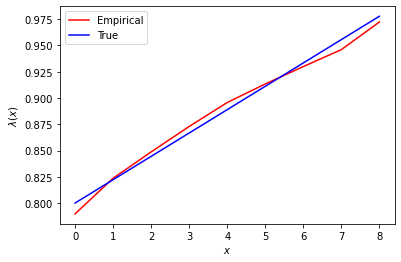

In [ ]:
# estimate ccp and weights
actual_ccp, actual_W, n_obs = ccp_fun(data_recursion)
# estimate success rates
T = 10
success_rates = np.ones((T,)) 
success_rates[0:T-1], n_obs_success_rates = p_acpt_fun(data_recursion)
# replace nan to 0
success_rates = np.array([x if np.isnan(x)==False else 0 for x in success_rates])
# plot estimated success rates v.s. theoretical success rates
%matplotlib inline
plt.figure()
plt.plot(range(0,T-1),success_rates[0:T-1],'r',label='Empirical')
plt.plot(range(0,T-1),[0.8 + 0.2/(T-1) * item for item in range(0,T-1)],'b',label = 'True')
plt.xlabel(r'$x$')
plt.ylabel(r'$\lambda(x)$')
plt.legend()
plt.show()




In [ ]:
# minimizing distance between predicted CCP and actual CCP
def predictCCPRecursion(success_rates, parameters):
    data = dataSimulationRecursion(parameters, success_rates)
    ccp, W, _ = ccp_fun(data)
    return ccp, W

def estimatorRecursion(parameters, actual_ccp, success_rates, actual_W):
    predicted_ccp, W = predictCCPRecursion(success_rates, parameters)
    distance = np.sum(np.multiply((predicted_ccp-actual_ccp)**2,W))
    return distance

In [ ]:
def estimationRecursion(data_recursion, parameter_combos):
    actual_ccp, actual_W, _ = ccp_fun(data_recursion)
    # estimate success rates
    T = 10
    success_rates = np.zeros((T,)) 
    success_rates[0:T-1] = p_acpt_fun(data_recursion)
    # replace nan to 0
    success_rates = [x if np.isnan(x)==False else 0 for x in success_rates]
    # grid search for minimum distance estimation
    estimatorNewRecursion = functools.partial(estimatorRecursion, actual_ccp=actual_ccp, 
                            success_rates=success_rates, actual_W=actual_W)
    obj = [estimatorNewRecursion(item) for item in parameter_combos]
    # find parameters that gives the minimum distance
    search_grid_sol = list(parameter_combos)[np.argmin(obj)]
    return search_grid_sol

In [ ]:
# grid search for minimum distance estimation
# true parameters = [-2.4, 8, 0.9]
theta0_vec = np.linspace(-8, 0, 12)
theta1_vec = np.linspace(0, 16, 12)
discount_vec = np.linspace(0.8, 1, 8)

parameter_combos = list(itertools.product(theta0_vec, theta1_vec, discount_vec))
estimatorNewRecursion = functools.partial(estimatorRecursion, actual_ccp=actual_ccp, 
                        success_rates=success_rates, actual_W=actual_W)

start = time.time()
obj = [estimatorNewRecursion(item) for item in parameter_combos]
end = time.time()

# find parameters that gives the minimum distance
search_grid_sol = parameter_combos[np.argmin(obj)]
print("The solution from the search-grid algorithm is :{}.\n \
      It took a total of {} seconds to compute".format(search_grid_sol, end-start))

The solution from the search-grid algorithm is :(-2.1818181818181817, 7.272727272727273, 0.9142857142857143).
       It took a total of 815.8725521564484 seconds to compute


In [ ]:
# traditional optimization
from scipy.optimize import minimize as smin
estimatorNewRecursion = functools.partial(estimatorRecursion, actual_ccp=actual_ccp, 
                        success_rates=success_rates, actual_W=actual_W)


print(smin(fun=estimatorNewRecursion, x0=(0, 2, 0.5)))

      fun: 0.034232482423680835
 hess_inv: array([[ 0.00122355,  0.03757455, -0.01508595],
       [ 0.03757455,  1.15389063, -0.46328   ],
       [-0.01508595, -0.46328   ,  0.18600407]])
      jac: array([-9504.49297   , 29456.5285044 , 21685.45363953])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 183
      nit: 2
     njev: 33
   status: 2
  success: False
        x: array([-1.20973739e-06,  1.99999925e+00,  4.99998583e-01])


## 4. Estimation Using Finite Dependence

It is easy to see that in our model, we can achieve 1-period finite dependence:
Suppose that at time $t$, you have accumulated $x_t$ years of experience. Let's consider the following two sequences of actions: 
* $(d_{t}=1,d_{t+1}=2)$:
\begin{align*}
  F(x_{t+1}|x_t,d_{t}=1) & = 
  \begin{cases}
   1 \ \ \ x_{t+1} = x_{t} \\
   0 \ \ \ \mbox{otherwise}
  \end{cases} \\
    F(x_{t+2}|x_{t+1},d_{t+1}=2) & = 
  \begin{cases}
   \lambda(x_{t+1}) \ \ \ x_{t+2} = x_{t+1} + 1 \\
   1- \lambda(x_{t+1}) \ \ \ x_{t+2} = x_{t+1}  \\
   0 \ \ \ \mbox{otherwise}
  \end{cases} 
\end{align*}
This implies that:
\begin{align*}
F(x_{t+2}|x_{t},(1,2)) & = 
\begin{cases}
  \lambda(x_t) \ \ x_{t+2}=x_{t}+1 \\ 
  1 - \lambda(x_t) \ \ x_{t+2}=x_{t} \\ 
  0 \ \ \ \mbox{otherwise}
\end{cases}
\end{align*}

* $(d_{t}=2,d_{t+1}=1)$:
\begin{align*}
  F(x_{t+1}|x_t,d_{t}=2) & = 
  \begin{cases}
   \lambda(x_t) \ \ \ x_{t+1} = x_{t} + 1 \\ 
   1 - \lambda(x_t) \ \ \ x_{t+1} = x_{t}  \\
   0 \ \ \ \mbox{otherwise}
  \end{cases} \\
    F(x_{t+2}|x_{t+1},d_{t+1}=1) & = 
  \begin{cases}
   1\ \ \ x_{t+2} = x_{t+1}  \\
   0 \ \ \ \mbox{otherwise}
  \end{cases} 
\end{align*}
This implies that:
\begin{align*}
F(x_{t+2}|x_{t},(2,1)) & = 
\begin{cases}
  \lambda(x_t) \ \ x_{t+2}=x_{t}+1 \\ 
  1 - \lambda(x_t) \ \ x_{t+2}=x_{t} \\ 
  0 \ \ \ \mbox{otherwise}
\end{cases}
\end{align*}
In this way, we have shown that:
\begin{align*}
  F(x_{t+2}|x_t,(1,2)) = F(x_{t+2}|x_{t},(2,1)) \ \ \ \forall x_{t+2} \in \mathcal{X}
\end{align*}
so that, we have established that the model has 1-period finite dependence. This holds true for any state $x_t \in \mathcal{X}$.


* When the errors are type one extreme value, we can use the following relation between the value function, the CCPs, and the conditional choice probabilities:
\begin{align}
    V_t(x_t) = v_{jt}(x_t) + \gamma - \log P_t(d_t=j|x_t) \ \ \ \forall t = 1, \cdots, T,  \ \ \forall x_{t} \in \mathcal{X} 
\end{align}

* Let's now exploit finite dependence. Let's compute the choice conditional value function for action $j=1$, i.e. when you decide to stay at home:
\begin{align*}
v_{1t} & = u_H(x_t) + \delta V_{t+1}(x_{t})  \\
& \mbox{Replace } V_{t+1} \mbox{ with }  v_{1t+1} \ \mbox{and the CCPs} \\
& = u_H(x_t) + \delta \left( v_{2t+1}(x_t) + \gamma - \log P_{t+1}(d_{t+1}=2|x_t)  \right) \\   
& \mbox{Telescope } v_{1t+1}  \\
& = u_H(x_t) + \delta \left[\lambda(x_t) \left( u_{W}(x_{t}) + \delta V_{t+2} (x_{t}+1)  \right)   + (1-\lambda(x_t))\left( u_{H}(x_t) + \delta V_{t+2}(x_{t})  \right) + \gamma - \log P_{t+1}(d_{t+1}=2|x_t)   \right] \\   
& \mbox{Rearrange} \\ 
& =  \delta \lambda(x_t)  \left(  \beta_{0} + \beta_1 x_{t}\right)  - \delta \log P_{t+1}(d_{t+1}=2|x_t)   + \delta \gamma + \delta^2 \lambda(x_t)V_{t+2}(x_t+1) + \delta^2 (1-\lambda(x_t)) V_{t+2} (x_t+1)                                  
\end{align*}

* Let's compute the choice conditional value function for action $j=2$, i.e. when you decide to apply for a job:
\begin{align*}
v_{2t} (x_t) & = \left( 1 - \lambda(x_t) \right) \left[ u_H(x_t) + \delta V_{t+1}(x_t)  \right] + \lambda(x_t) \left[ u_W(x_t) + \delta V_{t+1}(x_{t}+1)   \right] \\
& \mbox{Replace } V_{t+1} \mbox{ with } v_{1t+1} \ \mbox{and the CCPs} \\ 
&  = \left( 1 - \lambda(x_t) \right) \left[ u_H(x_t) + \delta \left( v_{1t+1}(x_t) + \gamma - \log P_{t+1}(d_{t+1}=1|x_{t})\right)  \right] + \lambda(x_t) \left[ u_W(x_t) + \delta \left( v_{1t+1}(x_t+1) + \gamma - \log P_{t+1}(d_{t+1}=1|x_{t}+1)\right) \right] \\
& \mbox{Telescope } v_{1t+1} \\
& = \left( 1 - \lambda(x_t) \right) \left[ u_H(x_t) + \delta \left( u_H(x_t) +\delta V_{t+2}(x_t) + \gamma - \log P_{t+1}(d_{t+1}=1|x_{t})\right)  \right] + \lambda(x_t) \left[ u_W(x_t) + \delta \left( u_H(x_t+1) + \delta V_{t+2}(x_{t}+1) + \gamma - \log P_{t+1}(d_{t+1}=1|x_{t}+1)\right) \right] \\
& \mbox{Rearrange} \\
 & = \lambda(x_t)\left( \beta_0 + \beta_1 x_t \right)  - \delta \lambda(x_t)\delta \log P_{t+1}(d_{t+1}=1|x_t+1) - \delta (1-\lambda(x_t))\delta P_{t+1}(d_{t+1}=1|x_{t})  + \delta \gamma + (1-\lambda(x_t)) \delta^2 V_{t+2}(x_t) + \lambda(x_t) \delta^2 V_{t+2}(x_t+1)
\end{align*}
* If we subtract the two, we obtain:
\begin{align*}
v_{2t}(x_t) - v_{1t}(x_t) & = \lambda(x_t) (1-\delta) \left( \beta_0 + \beta_1 x_t \right) + \delta \log P_{t+1} (d_{t+1}=2|x_t)- \delta \lambda(x_t) \log P_{t+1}(d_{t+1}=1|x_{t}+1) - \delta (1 - \lambda(x_t)) \log P_{t+1}(d_{t+1}=1|x_{t}) \\
& = (1-\delta) \beta_0 \lambda(x_t) + (1-\delta)\beta_1 x_t \lambda(x_t) + \delta \left(  \log P_{t+1} (d_{t+1}=2|x_t)- \lambda(x_t) \log P_{t+1}(d_{t+1}=1|x_{t}+1) - (1 - \lambda(x_t)) \log P_{t+1}(d_{t+1}=1|x_{t}) \right)
\end{align*}
* We relate the difference in the conditional value functions to the CCPs:
\begin{align*}
v_{2t}(x_t) - v_{1t}(x_t) & = \log P_t(d_t=2|x_t) - \log P_t(d_t=1|x_t) 
\end{align*}

* We now define the followng transformation of the structural parameters:
\begin{align*}
\theta_0 & = (1-\delta)\beta_0  \\  
\theta_1 & = (1-\delta)\beta_1  \\  
\theta_2 & = \delta &  \\
\end{align*}
* We define the following transformation of the observables variables:
\begin{align*}
z_{0t} & = \hat{\lambda}(x_t) \\
 z_{1t} & = x_t \hat{\lambda}(x_t) \\
z_{2t}  & =\left(  \log \hat{P}_{t+1} (d_{t+1}=2|x_t)- \hat{\lambda}(x_t) \log \hat{P}_{t+1}(d_{t+1}=1|x_{t}+1) - (1 - \hat{\lambda}(x_t)) \log \hat{P}_{t+1}(d_{t+1}=1|x_{t}) \right)  \\
y_t & = \log \hat{P}_t(d_t=2|x_t) - \log \hat{P}_t(d_t=1|x_t)
\end{align*}

* Now, we can define following linear equation, which is simply another way to rewrite the difference in the conditional value functions as a function of what we observe empirically and a transformation of the structural parameters. 
\begin{align*}
 y_t = \theta_
 0 z_{0t} + \theta_1 z_{1t} + \theta_2 z_{2t} + \varepsilon_t
\end{align*}

* It is important to notice that if instead of the empirical estimates of the CCPs and the transition probabilities, we had the actual true CCPs and transition probabilties, then the above equation would hold exactly. The estimation introduces some error, that it is important to take into account when we are making inferences. This is the reason why we introdice the error term $\varepsilon_t$. 

* What can we do now: we can estimate the structural parameters solving for a simple linear problem, as opposed to the a more complicated and computationally extensive non-linear problem that involves the entire solution of the model. 
Finally, we define: 
\begin{align*}
\boldsymbol{\theta} & =\left( \beta_0, \beta_1, \delta \right) \\
\mathbf{Z} & = \left( z_{0t}^i, z_{1t}^i, z_{2t}^i \right)_{i \in I, t \in T} \\
\mathbf{y} & = \left( y_{t}^i \right)_{i \in I, t \in T}
\end{align*}
* This is the problem we need to solve in order to obtain estimates of the structural parameters: 
\begin{align*}
\mathcal{L}(\boldsymbol{\theta}|\mathbf{Z},\mathbf{y}) & = || \mathbf{y} - Z \boldsymbol{\theta} ||_2^2 \\
\hat{\boldsymbol{\theta}}_{OLS} & = \arg\min_{\boldsymbol{\theta} \in \Theta} \mathcal{L}\left( \boldsymbol{\theta}| \mathbf{y},\mathbf{Z} \right)
\end{align*}




In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

def transform_data(data_recursion, actual_ccp, success_rates):

  index = [item for item in filter(lambda x: x[0]>=x[1], itertools.product(range(T),range(T)))]
  dict_ccps = {}
  for i in range(len(index)):
    age, exp = index[i]
    dict_ccps[str(age)+'-'+str(exp)] = actual_ccp[i]

  data_recursion['ccp2'] = np.nan
  data_recursion['ccp1'] = np.nan

  data_recursion['ccp2_next_same_experience'] = np.nan
  data_recursion['ccp1_next_more_experience'] = np.nan
  data_recursion['ccp1_next_same_experience'] = np.nan
  data_recursion['lambda'] = np.nan

  for (age,exp) in index:
  #for i in data_recursion.index:
    mask = (data_recursion['age'] == age) & (data_recursion['work_experience'] == exp)
    data_recursion.loc[mask,'ccp2'] = dict_ccps[str(age)+'-'+str(exp)]
    data_recursion.loc[mask,'ccp1'] = 1 - dict_ccps[str(age)+'-'+str(exp)] 
    data_recursion.loc[mask,'lambda'] = success_rates[exp]
    if age<np.max(data_recursion['age']):
      data_recursion.loc[mask,'ccp2_next_same_experience'] = dict_ccps[str(age+1)+'-'+str(exp)] 
      data_recursion.loc[mask,'ccp1_next_more_experience'] = 1 - dict_ccps[str(age+1)+'-'+str(exp+1)] 
      data_recursion.loc[mask,'ccp1_next_same_experience'] = 1 - dict_ccps[str(age+1)+'-'+str(exp)] 
    
  data_recursion['z0'] = data_recursion['lambda']
  data_recursion['z1'] = data_recursion['lambda'] * data_recursion['work_experience'] / T
  data_recursion['z2'] = np.log(data_recursion['ccp2_next_same_experience']) - data_recursion['lambda'] * np.log(data_recursion['ccp1_next_more_experience']) - (1 - data_recursion['lambda']) * np.log(data_recursion['ccp1_next_same_experience'])
  data_recursion['y'] = np.log(data_recursion['ccp2']) - np.log(data_recursion['ccp1'])

  return data_recursion

def estimation_finite_dependence(data_recursion):
  results = smf.ols('y ~ -1 + z0 + z1 + z2 ', data_recursion.replace([np.inf, -np.inf], np.nan)).fit()
  return results




/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
data_transformed = transform_data(data_recursion,actual_ccp,success_rates)
results = estimation_finite_dependence(data_transformed)

print(results.summary())

delta = results.params['z2']
beta_0 = results.params['z0'] / (1 - delta)
beta_1 = results.params['z1'] / (1 - delta)

print('Point Estimates. delta: ',np.round(delta,2),' beta_0: ', np.round(beta_0,2), ' beta_1', np.round(beta_1,2))
print('Original Values. delta: ',np.round(0.9,2),' beta_0: ', np.round(-2.4,2), ' beta_1', np.round(8,2))

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                          2.355e+06
Date:                Fri, 01 May 2020   Prob (F-statistic):                        0.00
Time:                        15:56:03   Log-Likelihood:                          14614.
No. Observations:               45000   AIC:                                 -2.922e+04
Df Residuals:                   44997   BIC:                                 -2.920e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

The question now is the follwoing: we have obtained the point estimates for the parameters. They look pretty good overall, as the are in a neighborhood of the true parameters. 

Now it is important to ask ourselves whether we can trust or not the values for the standard error derived ih the OLS regression. They look very small, and if we build confidence intervals based on these values, the estimated parameters would appear to be pretty far from the true ones. 

The main source of error in the estimation comes from the fact that we are **not** using the true CCP and transition probabilities, and that clearly introduces a source of error. How do we take into account this? One way is through bootstrapping. 



### Parametric Bootstrapping

* We can use bootstrap to estimate the standard errors of the coefficients. Specifically, we take $B$ resamples (with replacement) from the data, and estimate the coefficient for each subsample. Then calculate the standard error of the $B$ estimated coefficients.

$$ SE(\hat{\theta}) = \sqrt{\frac{1}{B-1} \sum_{b=1}^{B} (\hat{\theta}_b - \bar{\theta})^2} $$


* In the parametric bootstrapping, we use the asymptotic properties of the estimators for the CCPs and the transitiona probabilities. In this case, we have the space is discrete, and the empirical CCPs and transition are computed as averages of the indicator functions. Therefore,  we can use the Central Limit Theorem, and use the following asymptotic distribution when we resample in the bootstrapping: 
\begin{align*}
 P(d_{t}=1 |  x_t)_b & \approx \mathcal{N} \left( \hat{P}(d_{t}=1 |  x_t) , \frac{\left( 1 -\hat{P}(d_{t}=1 |  x_t) \right)\hat{P}(d_{t}=1 |  x_t) } {n(x_t)}\right) \\
 P(d_{t}=2 |  x_t)_b & \approx \mathcal{N} \left( 1 - \hat{P}(d_{t}=1 |  x_t) , \frac{\left( 1 -\hat{P}(d_{t}=1 |  x_t) \right)\hat{P}(d_{t}=1 |  x_t) } {n(x_t)}\right)  \\ 
\lambda (x_t)_b & \approx \mathcal{N} \left( \hat{\lambda}(x_t) , \frac{\left( 1 -\hat{\lambda}(x_t)) \right)\hat{\lambda}(x_t)} {n(x_t)}\right)
\end{align*}
* For each $b=1,\cdots,B$:
  * For each $x_{t} \in \mathcal{X}$: 
    * Sample $\hat{P}(d_{t}=1 |  x_t)_b$, $\hat{P}(d_{t}=2 |  x_t)_b$ and $\hat{\lambda}(x_{t})_b$ from the distributions defined above
    * Compute $(z_{0t,b}^i,z_{1t,b}^i,z_{2t,b}^i,y_{t,b}^i)_{i \in I, t \in T}$
    * Run and OLS regression, estimate $\hat{\boldsymbol{\theta}}_b$, and derive $\hat{\beta}_{0,b}, \hat{\beta}_{1,b}, \hat{\delta}_{0,b}$

In [ ]:
from sklearn.utils import resample

def getResample(data):
    individuals = list(set(data.individual.values))
    groups = data.groupby('individual')
    sub_index = resample(individuals, replace=True, n_samples=len(individuals))
    subsample = pd.concat([groups.get_group(i) for i in sub_index])
    return subsample

def ParametricBootstrapEstimation(args):
    data, n_bootstrap, actual_ccp, success_rates = args
    coeffs = []
    asympt_std_ccp = np.sqrt( actual_ccp * (1-actual_ccp) / n_obs )
    asympt_std_success_rates = np.sqrt( success_rates * (1 - success_rates) / n_obs_success_rates )

    for i in range(n_bootstrap):

        bootstrap_ccp = np.random.normal(actual_ccp,asympt_std_ccp)
        bootstrap_success_rates = np.random.normal(success_rates,asympt_std_success_rates)
        bootstrap_data_transformed = transform_data(data,bootstrap_ccp,bootstrap_success_rates)
        results_bootstrap = estimation_finite_dependence(bootstrap_data_transformed)
        coeffs.append(results_bootstrap.params)
    
    return coeffs







In [ ]:
start = time.time()
bootstrap_args = (data_recursion,250,actual_ccp,success_rates)
bootstrap_coeffs = ParametricBootstrapEstimation(bootstrap_args)
print('total computation time is %.2f' %(time.time()-start))

bootstrap_coeffs = np.array(bootstrap_coeffs)
delta_b = bootstrap_coeffs[:,2]
beta_0_b = bootstrap_coeffs[:,0] / (1 - delta_b)
beta_1_b = bootstrap_coeffs[:,1] / (1 - delta_b)

bootstrap_standard_errors = np.std(np.c_[beta_0_b, beta_1_b, delta_b],axis=0)
print('standard errors are %.4f for beta_0 %.4f for beta_1 and \
        %.4f for discount factor' %tuple(bootstrap_standard_errors))







/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


total computation time is 141.77


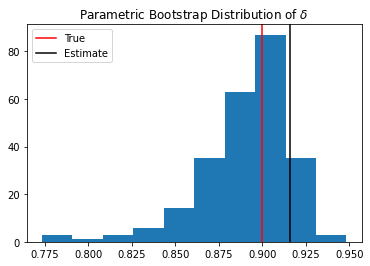

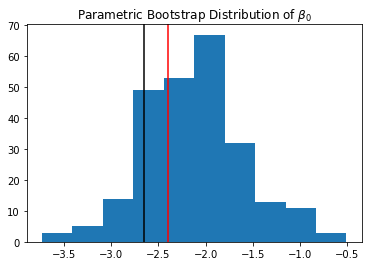

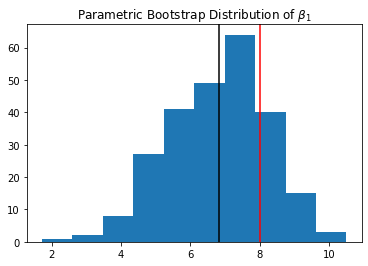

In [ ]:
plt.figure()
plt.title(r'Parametric Bootstrap Distribution of $\delta$')
plt.hist(delta_b)
plt.axvline(x=0.9,c='r',label='True')
plt.axvline(x=delta,c='k',label='Estimate')
plt.legend()
plt.show()

plt.figure()
plt.title(r'Parametric Bootstrap Distribution of $\beta_0$')
plt.hist(beta_0_b)
plt.axvline(x=-2.4,c='r',label='True')
plt.axvline(x=beta_0,c='k',label='Estimate')
plt.show()

plt.figure()
plt.title(r'Parametric Bootstrap Distribution of $\beta_1$')
plt.hist(beta_1_b)
plt.axvline(x=8,c='r',label='True')
plt.axvline(x=beta_1,c='k',label='Estimate')
plt.show()

### Non Parametric Bootstrapping

* There may be some disadvantages to the non-parametric bootstrapping. For instance, it can be the case that the distribution from which we are sampling the CCPs and the transition probabilities does not well represent the true underlying distribution. 

* Considering that we are using asymptotic properties, this can be the case when there are not enough observations in each of the cells of the state space. In our case, this can be an issue, especially for higher values of experience. This is because ending into high value of experience depends jointly on someone's choice and and exogenuous stochastic process.

* In order to alleviate this problem, we can still do bootstrapping, without making any assumption as to what the distribution of the CCPs or the empirical probabilities look like, so that we do not need to rely on asymptotic properties.

* In this case, we resample with replacement from the empirical distribution of individuals. 

* Example: Suppose that we have $I = \lbrace Ann, Beth, Carl, Donnie \rbrace$.
Resampling with replacement mean that we pick randomly a $|I|$ individuals from the sample, allowing an individual to be picked possibly multiple time. 
  * $I_{b1} = \lbrace Ann, Ann, Carl, Donnie \rbrace$ \\
  * $I_{b2} = \lbrace Ann, Ann, Carl, Carl \rbrace$


* For $b=1,\cdots,B$:
  * Resample $I$ individuals, and call the new sample $I_b$
  * Based on the observations contained in $I_b$, compute $\hat{P}_{1b}(d_1=1|x_t)$, and $\hat{\lambda}_b(x_t)$
  * Compute $(z_{0t,b}^i,z_{1t,b}^i,z_{2t,b}^i,y_{t,b}^i)_{i \in I, t \in T}$
  * Run an OLS regression, estimate $\hat{\boldsymbol{\theta}}_b$, and derive $\hat{\beta}_{0,b}, \hat{\beta}_{1,b}, \hat{\delta}_{0,b}$


In [ ]:
def NonParametricBootstrapEstimation(args):
 
    data, n_bootstrap, actual_ccp, success_rates = args
    coeffs = []

    for i in range(n_bootstrap):

        bootstrap_data = getResample(data)
        bootstrap_ccp, _, _ = ccp_fun(bootstrap_data)
        bootstrap_success_rates = p_acpt_fun(bootstrap_data)
        bootstrap_success_rates = [x if np.isnan(x)==False else 0 for x in success_rates]
        bootstrap_data_transformed = transform_data(bootstrap_data,bootstrap_ccp,bootstrap_success_rates)
        results_bootstrap = estimation_finite_dependence(bootstrap_data_transformed)
        coeffs.append(results_bootstrap.params)
    
    return coeffs

In [ ]:
start = time.time()
bootstrap_args = (data_recursion,250,actual_ccp,success_rates)
bootstrap_coeffs = NonParametricBootstrapEstimation(bootstrap_args)
print('total computation time is %.2f' %(time.time()-start))

bootstrap_coeffs = np.array(bootstrap_coeffs)
delta_b = bootstrap_coeffs[:,2]
beta_0_b = bootstrap_coeffs[:,0] / (1 - delta_b)
beta_1_b = bootstrap_coeffs[:,1] / (1 - delta_b)

bootstrap_standard_errors = np.std(np.c_[beta_0_b, beta_1_b, delta_b],axis=0)
print('standard errors are %.4f for beta_0 %.4f for beta_1 and \
        %.4f for discount factor' %tuple(bootstrap_standard_errors))

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


total computation time is 683.52
standard errors are 0.4155 for beta_0 1.2629 for beta_1 and         0.0178 for discount factor


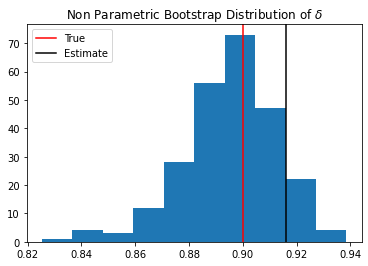

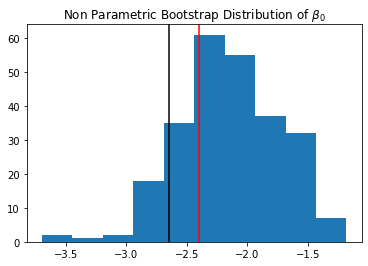

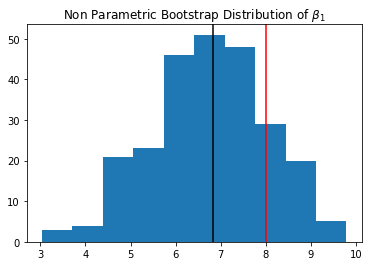

In [ ]:
plt.figure()
plt.title(r'Non Parametric Bootstrap Distribution of $\delta$')
plt.hist(delta_b)
plt.axvline(x=0.9,c='r',label='True')
plt.axvline(x=delta,c='k',label='Estimate')
plt.legend()
plt.show()

plt.figure()
plt.title(r'Non Parametric Bootstrap Distribution of $\beta_0$')
plt.hist(beta_0_b)
plt.axvline(x=-2.4,c='r',label='True')
plt.axvline(x=beta_0,c='k',label='Estimate')
plt.show()

plt.figure()
plt.title(r'Non Parametric Bootstrap Distribution of $\beta_1$')
plt.hist(beta_1_b)
plt.axvline(x=8,c='r',label='True')
plt.axvline(x=beta_1,c='k',label='Estimate')
plt.show()